In [9]:
import pandas as pd
import numpy as np
from sortedcontainers import SortedList
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%run util.ipynb

In [2]:
# Create a class for KNN models
class KNN (object):
    
    # Initialize the class with the number of nearest neighbours the model will use
    def __init__(self, k):
        self.k = k
    
    # Since kNN is considered a 'lazy' algorithm, it doesn't spend much time fitting.
    # Basically just describing what the training data is below
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    # Predict is where the magic happens
    def predict(self, X):
        # We've passed it the data X to predict, so we will store our predictions in this array y of length X. 
        y = np.zeros(len(X))
        
        # For every row in the data being predicted
        for i, x in enumerate(X):
            
            # Create a list that will hold the sorted k minimized distances between this data point and the training data
            sl = SortedList(load = self.k)
            
            # Every row in the data being predicted will be compared to every row in the training data
            for j, xt in enumerate(self.X):
                
                # Find the mean-squared difference between the data point and each row in the training data
                diff = x - xt
                d = diff.dot(diff)
                
                # If the sorted list doesn't already have k items, add the distance and the corresponding prediction label
                if len(sl) < self.k:
                    sl.add((d, self.y[j]))
                else:
                # Otherwise, only add a distance to the list if it is smaller than the biggest distance already in the list
                # This corresponds to the list item in the sorted list
                    if d < sl[-1][0]:
                        del sl[-1]
                        sl.add((d, self.y[j]))
            
            # Now we have k items in the sorted list with minimized distance from our data point
            # Let's find what the most frequent class label is by converting the list into a dictionary with counts
            votes = {}
            
            # The _ is the distance which is irrelevant at this point, the v is the class prediction label
            for _, v in sl:
                votes[v] = votes.get(v, 0) + 1  # the get command returns 0 if key v isn't found in the dictionary
            
            # Finds the key with the highest value in the dictionary by going across the dictionary and then taking the max
            y[i] = max(votes, key = lambda n: votes[n])
                        
            # y[i] above represents the prediction based on the most frequent class prediction labels
            # associted with the nearest neighbours
        return y
    
    # Basically runs the prediction on the given data X and then compares it to the value values
    # The mean essentially takes the average which is the total number of correct guesses divided by the total number guesses
    def score(self, X, Y):
        P = self.predict(X)
        return np.mean(P == Y)

In [3]:
# Reminder that the data is in the form of a 28 by 28 matrix which represents an image containing a number
# The matrix is presented in vector form where each row corresponds to a number with 784 dimensions (28 x 28)

if __name__ == '__main__':

    # Grab the data
    records = 2000
    X, Y = get_data(records)

    # Split it into two groups: one for training and another for testing
    split = int(records / 2)
    Xtrain, Ytrain = X[:split], Y[:split]
    Xtest, Ytest = X[split:], Y[split:]

    train_scores = []
    test_scores = []

    print("Starting...")

    # Run the model with different values of k
    for k in [1,2,3,4,5]:
        knn = KNN(k)

        t0 = datetime.now()
        knn.fit(Xtrain, Ytrain)
        #print("k = ", k, "\n-----", "\nTraining time: ", datetime.now() - t0)

        t0 = datetime.now()
        trainscore = knn.score(Xtrain, Ytrain)
        #print("Train Accuracy: ", trainscore, ", time: ", datetime.now() - t0)

        t0 = datetime.now()
        testscore =  knn.score(Xtest, Ytest)
        #print("Test Accuracy: ", testscore , ", time: ", datetime.now() - t0, "\n")

        train_scores.append((k,trainscore))
        test_scores.append((k, testscore))
        print ("k =", k, "is now complete.")

    train_df = pd.DataFrame(train_scores, columns = ['k','score'])
    test_df = pd.DataFrame(test_scores, columns = ['k','score'])

    train_df['Type'] = 'Train'
    test_df['Type'] = 'Test'

    result = pd.concat([train_df, test_df])
    result

Starting...
k = 1 is now complete.
k = 2 is now complete.
k = 3 is now complete.
k = 4 is now complete.
k = 5 is now complete.


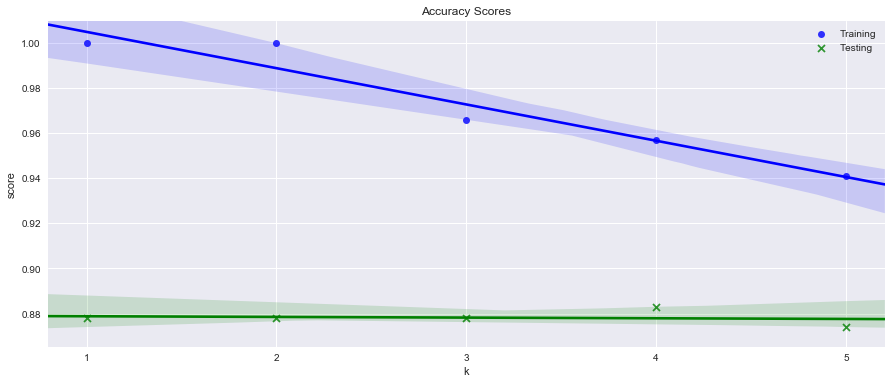

In [4]:
# Visualizing the data 

plt.figure(figsize=(15,6))
sns.regplot(x = 'k', y = 'score', data = train_df, marker = 'o', color = 'b', label = 'Training')
sns.regplot(x = 'k', y = 'score', data = test_df, marker = 'x', color = 'g', label = 'Testing')
plt.title("Accuracy Scores")
plt.legend()
plt.xticks((1,2,3,4,5))
plt.ylim(ymax = 1.01);

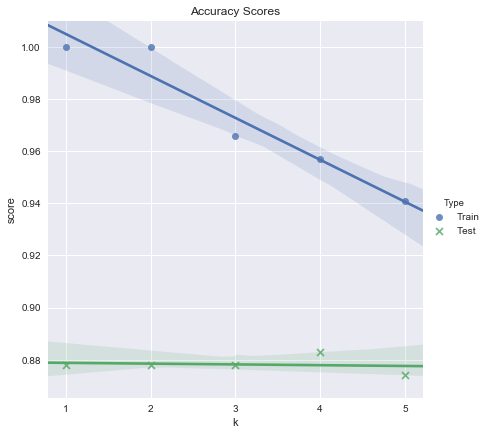

In [5]:
# Alternate Visualization Technique (Combining into one DataFrame)

plt.figure(figsize=(15,6))
sns.pairplot(x_vars = 'k', y_vars = 'score', data = result, hue = 'Type', markers = ['o', 'x'], kind = 'reg', size = 6);
plt.title("Accuracy Scores")
plt.xticks((1,2,3,4,5))
plt.ylim(ymax = 1.01);

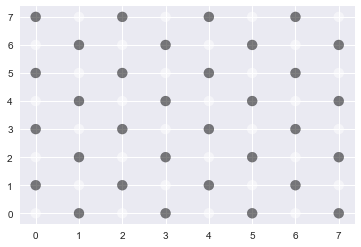

Train accuracy: 0.0


In [6]:
# Case where kNN fails: Alternating points (train accuracy of 0)

# Visualizing it, look at X for an understanding of how it's working
if __name__ == '__main__':
    X, Y = get_data_failure()
    
    # Creating the plot with color defined by Y
    # X[:,0] are all i values, X[:,1] are all j values
    # Combined this gives us all N (i,j) points
    plt.scatter(X[:,0], X[:, 1], s = 100, c = Y, alpha = 0.5)
    plt.show()
    
    # Create the model, fit it to the data and observe the training accuracy
    model = KNN(3)
    model.fit(X,Y)
    print("Train accuracy:", model.score(X,Y))

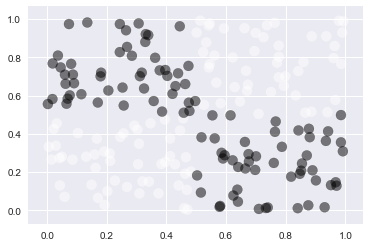

Train accuracy: 0.965


In [7]:
# Looking at the XOR Problem (data is not linearly separable but kNN still works)
# 00 -> 0, 11 -> 0, 01 -> 1, 10 -> 1

if __name__ == '__main__':
    X, Y = get_xor()
    
    # quadrants represent XOR problem, white are 0, black are 1
    # when i and j ranges are matched, it's a 0 as per the XOR
    # when i and j ranges are mismatched, it's a 1 as per the XOR
    plt.scatter(X[:,0], X[:,1], s = 100, c = Y, alpha = 0.5)
    plt.show()
    
    # fitting the model, good accuracy
    model = KNN(3)
    model.fit(X,Y)
    print("Train accuracy:", model.score(X,Y))

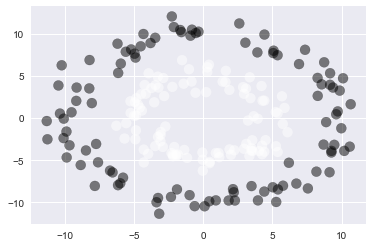

Train accuracy: 0.995


In [10]:
# Donut Problem (data still isn't linearly seperable)
# Small circle inside a bigger circle

if __name__ == '__main__':
    X,Y = get_donut()
    
    plt.scatter(X[:,0], X[:,1], s = 100, c = Y, alpha = 0.5)
    plt.show()
    
    # fitting the model, good accuracy
    model = KNN(3)
    model.fit(X,Y)
    print("Train accuracy:", model.score(X,Y))